In [1]:
import json
import numpy as np
from matplotlib import pyplot as plt

In [2]:
PATH = "data/2024-11-09_11-10-06-algific"
# PATH = "data/2024-11-09_13-11-13-premotion"

In [3]:
# data/1731122195-monosiphonous - My first long run
# data/2024-11-09_11-10-06-algific - Ran with large cache
# data/2024-11-09_13-11-13-premotion - Ran with no cache

events = []
with open(f"../{PATH}/logs.txt") as f:
    logs = f.readlines()
    for line in logs:
        # Skip lines that are not events.
        if not line.startswith("event | "):
            continue

        _, timestamp, event, params = line.strip().split(" | ")
        events.append((float(timestamp), event, json.loads(params)))

# Sort events by timestamp.
events.sort(key=lambda x: x[0])

# Adjust timestamps to start at 0.
start_time = events[0][0]
events = [
    (timestamp - start_time, event, params)
    for timestamp, event, params in events
]


In [4]:
cache_stats = [e for e in events if e[1] == "cache_stats"]

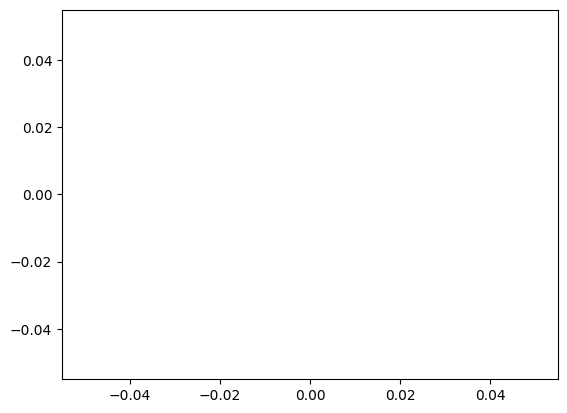

In [5]:
plt.plot(
    [e[0] for e in cache_stats],
    [e[2]["hit_rate"] for e in cache_stats],
)

In [6]:
# boards = []
# board_bytes_set = set()
# full_bytes_set = set()

# for i in range(len(cache_events)):
#     bytestring = eval(cache_events[i][2]["cache_key"])
#     board_bytes = bytestring[:(4 * 10 * 10)]
#     move_indices_bytes = bytestring[(4 * 10 * 10):]

#     board_bytes_set.add(board_bytes)
#     full_bytes_set.add(bytestring)

#     board = np.frombuffer(board_bytes, dtype=bool).reshape((4, 10, 10))
#     move_indices = np.frombuffer(move_indices_bytes, dtype=np.int64).reshape((-1))

#     boards.append(board)

In [7]:
# len(full_bytes_set)

In [8]:
# evaluations = [e for e in cache_events if e[2]["result"] == "none"]

In [9]:
# len([e for e in cache_events if e[2]["result"] == "done"])

In [10]:
# len(evaluations)

In [11]:
# sum([1 for e in events if e[1] == "fetch_evaluation_params"])

In [12]:
# len(board_sums)

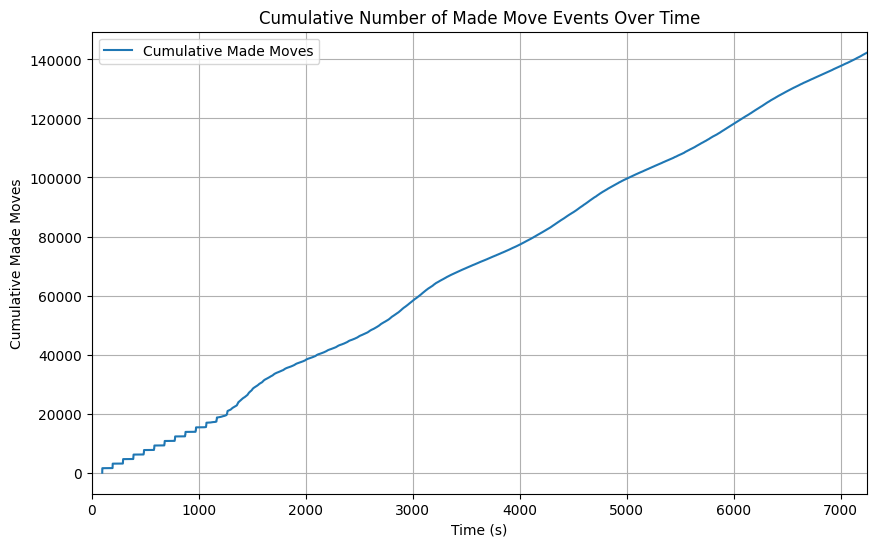

In [13]:
timestamps = [event[0] for event in events if event[1] == "made_move"]
cumulative_made_moves = list(range(1, len(timestamps) + 1))

plt.figure(figsize=(10, 6))
plt.plot(timestamps, cumulative_made_moves, label='Cumulative Made Moves')
plt.xlabel('Time (s)')
plt.ylabel('Cumulative Made Moves')
plt.title('Cumulative Number of Made Move Events Over Time')
plt.legend()
plt.grid(True)
plt.xlim(left=0, right=max(e[0] for e in events))
plt.show()

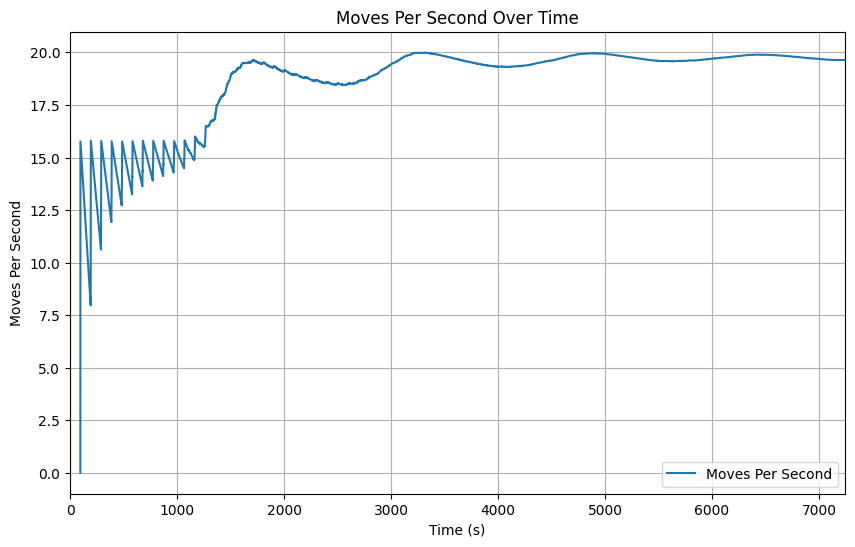

19.957851616827583


In [14]:
moves_per_second = []

moves_made = 0
for event in events:
    if event[1] != "made_move":
        continue
    moves_made += 1

    moves_per_second.append(moves_made / event[0])

plt.figure(figsize=(10, 6))
plt.plot([event[0] for event in events if event[1] == "made_move"], moves_per_second, label='Moves Per Second')
plt.xlabel('Time (s)')
plt.ylabel('Moves Per Second')
plt.title('Moves Per Second Over Time')
plt.legend()
plt.grid(True)
plt.xlim(left=0, right=max(e[0] for e in events))
plt.show()

final_moves_per_sec = max(
    moves_per_second[len(moves_per_second) // 2:]
)
print(final_moves_per_sec)

In [15]:
total_duration = 0
total_evaluated = 0
for event in events:
    if event[1] == "gpu_evaluation":
        total_duration += event[2]["duration"]
        total_evaluated += event[2]["batch_size"]

# GPU bottleneck. Closer to 1 means that the GPU is the bottleneck because the
# moves per second we actually got is close to the theoretical maximum based on
# GPU evaluation speed.
# 
# This won't work when using caching.
print(final_moves_per_sec / ((total_evaluated / total_duration) / 500))

1.226959206823727


In [16]:
# What percent of time is the GPU thread being used?

evaluations = [event[0] for event in events if event[1] == "gpu_evaluation"]
total_duration / (max(evaluations) - min(evaluations))

0.9331862008555498

In [17]:
# What is the average batch size?

batch_sizes = [event[2]["batch_size"] for event in events if event[1] == "gpu_evaluation"]
sum(batch_sizes) / len(batch_sizes)

128.0

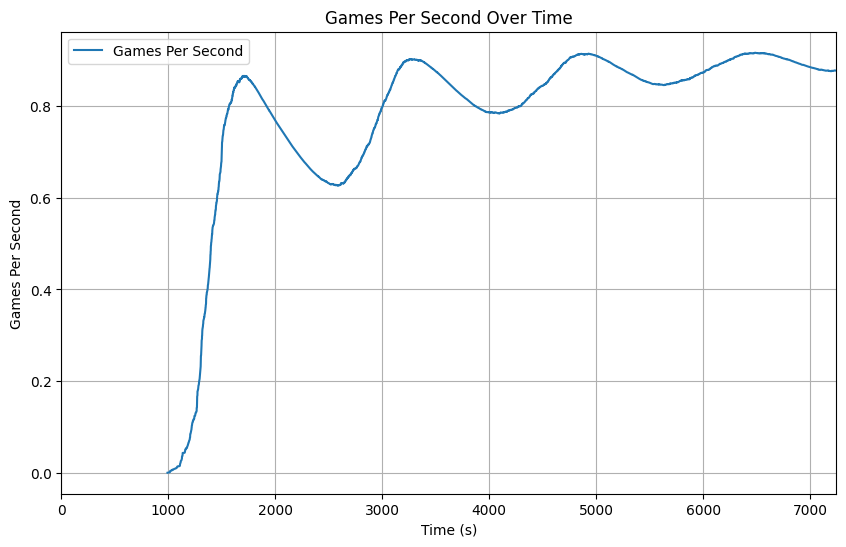

In [18]:
games_per_second = []

games_finished = 0
for event in events:
    if event[1] != "game_end":
        continue
    games_finished += 1

    games_per_second.append(games_finished / event[0])

plt.figure(figsize=(10, 6))
plt.plot([event[0] for event in events if event[1] == "game_end"], games_per_second, label='Games Per Second')
plt.xlabel('Time (s)')
plt.ylabel('Games Per Second')
plt.title('Games Per Second Over Time')
plt.legend()
plt.grid(True)
plt.xlim(left=0, right=max(e[0] for e in events))
plt.show()

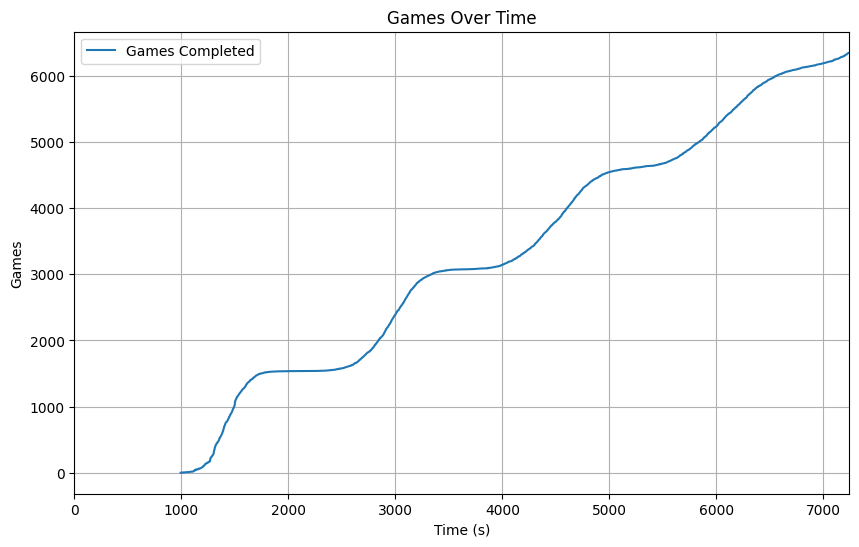

In [19]:
games_finished = 0
games_finished_counts = []
for event in events:
    if event[1] != "game_end":
        continue
    games_finished += 1
    games_finished_counts.append(games_finished)

plt.figure(figsize=(10, 6))
plt.plot([event[0] for event in events if event[1] == "game_end"], games_finished_counts, label='Games Completed')
plt.xlabel('Time (s)')
plt.ylabel('Games')
plt.title('Games Over Time')
plt.legend()
plt.grid(True)
plt.xlim(left=0, right=max(e[0] for e in events))
plt.show()

In [20]:
import scipy.stats

Slope: 0.9970441612980373
Intercept: -667.8717922295473
R-squared: 0.9869166506506716


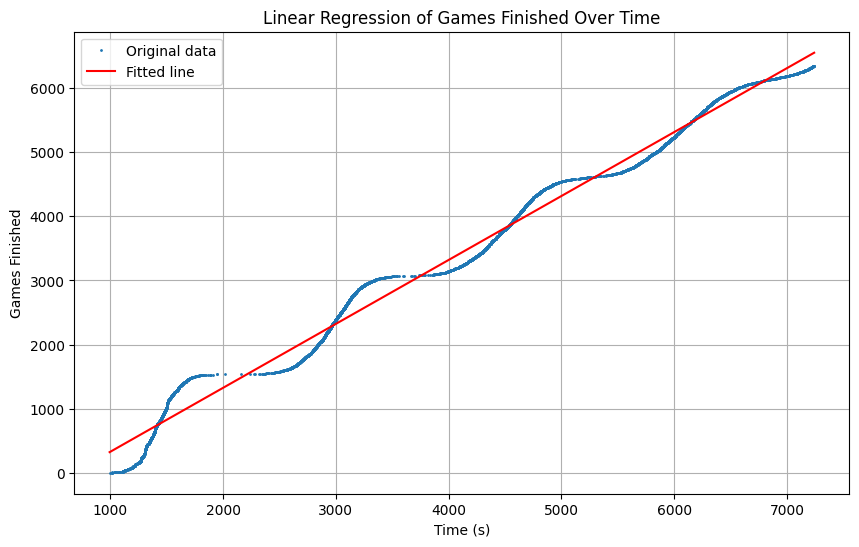

In [21]:
# Prepare the data for linear regression
x = [event[0] for event in events if event[1] == "game_end"][:7000]
y = games_finished_counts[:7000]

# Perform linear regression
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)

# Print the results
print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared: {r_value**2}")

# Plot the regression line
plt.figure(figsize=(10, 6))
plt.plot(x, y, 'o', label='Original data', markersize=1)  # Made the dots smaller by reducing markersize
plt.plot(x, [slope * xi + intercept for xi in x], 'r', label='Fitted line')
plt.xlabel('Time (s)')
plt.ylabel('Games Finished')
plt.title('Linear Regression of Games Finished Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [22]:

# Prepare the data for linear regression
x_made_move = [event[0] for event in events if event[1] == "made_move"][:18]
y_made_move = [i for i, event in enumerate(events) if event[1] == "made_move"]

# Perform linear regression
slope_made_move, intercept_made_move, r_value_made_move, p_value_made_move, std_err_made_move = scipy.stats.linregress(x_made_move, y_made_move)

# Print the results
print(f"Slope: {slope_made_move}")
print(f"Intercept: {intercept_made_move}")
print(f"R-squared: {r_value_made_move**2}")

# Plot the regression line
plt.figure(figsize=(10, 6))
plt.plot(x_made_move, y_made_move, 'o', label='Original data', markersize=1)  # Made the dots smaller by reducing markersize
plt.plot(x_made_move, [slope_made_move * xi + intercept_made_move for xi in x_made_move], 'r', label='Fitted line')
plt.xlabel('Time (s)')
plt.ylabel('Moves Made')
plt.title('Linear Regression of Moves Made Over Time')
plt.legend()
plt.grid(True)
plt.show()



ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 18 and the array at index 1 has size 142260